This code has ONLY been tested on Google Colab

Imports and Installations

In [ ]:
!pip install -U pip setuptools wheel
!pip install torch torchvision
!pip install diffusers transformers accelerate safetensors

In [ ]:
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import callbacks, layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

plt.style.use("seaborn-v0_8-whitegrid")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Load metadata and set up paths

In [ ]:
# Download latest version
path = kagglehub.dataset_download("meetnagadia/human-action-recognition-har-dataset")

print("Path to dataset files:", path)

100%|██████████| 297M/297M [00:14<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meetnagadia/human-action-recognition-har-dataset/versions/1


In [ ]:
data_dir = Path(path+"/Human Action Recognition")
train_csv = data_dir / "Training_set.csv"
test_csv = data_dir / "Testing_set.csv"
train_img_dir = data_dir / "train"
test_img_dir = data_dir / "test"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
display(train_df.head())


Train rows: 12600 | Test rows: 5400
Train columns: ['filename', 'label']
Test columns: ['filename']


,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


Basic data quality checks

In [ ]:
# Check for missing values and duplicates
missing = train_df.isna().sum()
duplicate_rows = train_df.duplicated().sum()

print("Missing values per column:\n", missing)
print(f"\nDuplicate rows: {duplicate_rows}")

# Label distribution across the full training set
label_counts = train_df["label"].value_counts().sort_values(ascending=False)
print("\nLabel distribution (counts):")
print(label_counts)
print("\nLabel distribution (percent):")
print((label_counts / len(train_df) * 100).round(2))


Missing values per column:
 filename    0
label       0
dtype: int64

Duplicate rows: 0

Label distribution (counts):
label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

Label distribution (percent):
label
sitting               6.67
using_laptop          6.67
hugging               6.67
sleeping              6.67
drinking              6.67
clapping              6.67
dancing               6.67
cycling               6.67
calling               6.67
laughing              6.67
eating                6.67
fighting              6.67
listening_to_music    6.67
running               6.67
texting               6.67
Name: count, dtype

Add resolved file paths and validate availability

In [ ]:
# Add absolute-style paths and verify the files exist on disk
train_df["filepath"] = train_df["filename"].apply(lambda x: train_img_dir / x)
test_df["filepath"] = test_df["filename"].apply(lambda x: test_img_dir / x)

missing_train_files = train_df[~train_df["filepath"].apply(Path.exists)]
missing_test_files = test_df[~test_df["filepath"].apply(Path.exists)]

print(f"Missing train images: {len(missing_train_files)}")
print(f"Missing test images: {len(missing_test_files)}")
if not missing_train_files.empty:
    display(missing_train_files.head())
if not missing_test_files.empty:
    display(missing_test_files.head())


Missing train images: 0
Missing test images: 0


Train/validation split and label encoding

In [ ]:
# Encode labels and create stratified train/validation splits
label_encoder = LabelEncoder()
train_df["label_idx"] = label_encoder.fit_transform(train_df["label"])

train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"],
)

print(f"Train split: {len(train_split)} rows")
print(f"Validation split: {len(val_split)} rows")
print(f"Test rows (no labels provided): {len(test_df)}")

train_split_counts = train_split["label"].value_counts().sort_values(ascending=False)
val_split_counts = val_split["label"].value_counts().sort_values(ascending=False)
print("Train split label distribution (by name):")
print(train_split_counts)
print("Validation split label distribution (by name):")
print(val_split_counts)

train_split_counts_idx = train_split["label_idx"].value_counts().sort_index()
print("Train split label distribution (by index):")
print(train_split_counts_idx)

num_classes = train_split_counts_idx.shape[0]
total_samples = len(train_split)

class_weights = {
    int(cls_idx): float(total_samples / (num_classes * count))
    for cls_idx, count in train_split_counts_idx.items()
}

print("Class weights (class index -> weight):")
print(class_weights)


Train split: 10080 rows
Validation split: 2520 rows
Test rows (no labels provided): 5400

Train split label distribution (by name):
label
cycling               672
dancing               672
hugging               672
running               672
clapping              672
eating                672
laughing              672
texting               672
sitting               672
drinking              672
listening_to_music    672
calling               672
using_laptop          672
fighting              672
sleeping              672
Name: count, dtype: int64

Validation split label distribution (by name):
label
clapping              168
sleeping              168
using_laptop          168
fighting              168
calling               168
hugging               168
sitting               168
cycling               168
drinking              168
eating                168
running               168
listening_to_music    168
dancing               168
texting               168
laughing              168
Na

Visualize label distribution

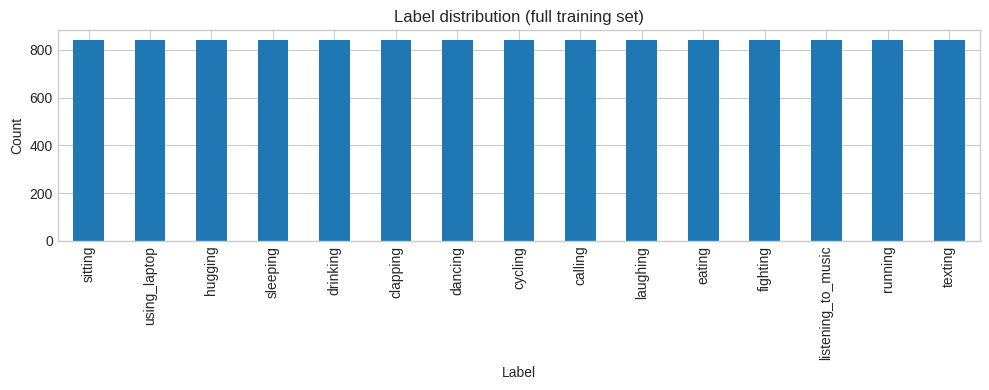

In [ ]:
label_counts_full = train_df["label"].value_counts().sort_values(ascending=False)
label_counts_full.plot(kind="bar", figsize=(10, 4))
plt.title("Label distribution (full training set)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


ResNet50 Train and validation

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20  # adjust as needed

num_classes = train_df["label_idx"].nunique()

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    return img, label

def load_and_preprocess_train(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = preprocess_input(img)
    return img, label

train_paths = train_split["filepath"].astype(str).values
train_labels = train_split["label_idx"].values

val_paths = val_split["filepath"].astype(str).values
val_labels = val_split["label_idx"].values

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(buffer_size=len(train_paths))
    .map(load_and_preprocess_train, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

loss_fn = "sparse_categorical_crossentropy"

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=["accuracy"],
)

model.summary()

early_stop = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
)

checkpoint = callbacks.ModelCheckpoint(
    "resnet50_best.keras",
    monitor="val_loss",
    save_best_only=True,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights,
)

fine_tune_at = 140
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=["accuracy"],
)

fine_tune_epochs = 15

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights,
)

val_loss, val_acc = model.evaluate(val_ds)
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        30,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 30,735 (120.06 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.4024 - loss: 2.0201 - val_accuracy: 0.6690 - val_loss: 1.0594 - learning_rate: 0.0010
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6484 - loss: 1.0977 - val_accuracy: 0.6909 - val_loss: 0.9937 - learning_rate: 0.0010
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6893 - loss: 0.9492 - val_accuracy: 0.6901 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7046 - loss: 0.9069 - val_accuracy: 0.7012 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7297 - loss: 0.8452 - val_accuracy: 0.6921 - val_loss: 1.0192 - learning_rate: 0.0010
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7281 - loss: 0.8129 - val_accuracy: 0.6960 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7530 - loss: 0

## Test-time predictions
Generate predictions on the held-out test split using the saved ResNet50 model.

In [ ]:
def load_and_preprocess_infer(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    return img

idx_to_label = {idx: cls for idx, cls in enumerate(label_encoder.classes_)}

test_paths = test_df['filepath'].astype(str).values
test_ds = (
    tf.data.Dataset.from_tensor_slices(test_paths)
    .map(load_and_preprocess_infer, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

loaded_model = tf.keras.models.load_model('resnet50_best.keras')
probs = loaded_model.predict(test_ds)
pred_idx = probs.argmax(axis=1)

test_predictions = test_df.copy()
test_predictions['pred_label'] = [idx_to_label[i] for i in pred_idx]
test_predictions['pred_confidence'] = probs.max(axis=1)

display(test_predictions.head(15))


169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step


,filename,filepath,pred_label,pred_confidence
0,Image_1.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,sleeping,0.700925
1,Image_2.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,eating,0.994003
2,Image_3.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,running,0.971181
3,Image_4.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,eating,0.857758
4,Image_5.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,texting,0.760871
5,Image_6.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,clapping,0.999238
6,Image_7.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,running,0.668184
7,Image_8.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,sitting,0.952774
8,Image_9.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,laughing,0.863509
9,Image_10.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,drinking,0.998296


## Confusion matrix
Evaluate the validation split with the best checkpoint and visualize misclassifications.

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Validation classification report:                     precision    recall  f1-score   support

           calling       0.65      0.65      0.65       168
          clapping       0.74      0.77      0.75       168
           cycling       0.95      0.99      0.97       168
           dancing       0.80      0.76      0.78       168
          drinking       0.79      0.71      0.75       168
            eating       0.85      0.89      0.87       168
          fighting       0.83      0.79      0.81       168
           hugging       0.74      0.84      0.79       168
          laughing       0.78      0.76      0.77       168
listening_to_music       0.72      0.67      0.70       168
           running       0.85      0.82      0.83       168
           sitting       0.60      0.62      0.61       168
          sleeping       0.84      0.89      0.87       168
           texting       0.64      0.65      0.65       168
      using_laptop      

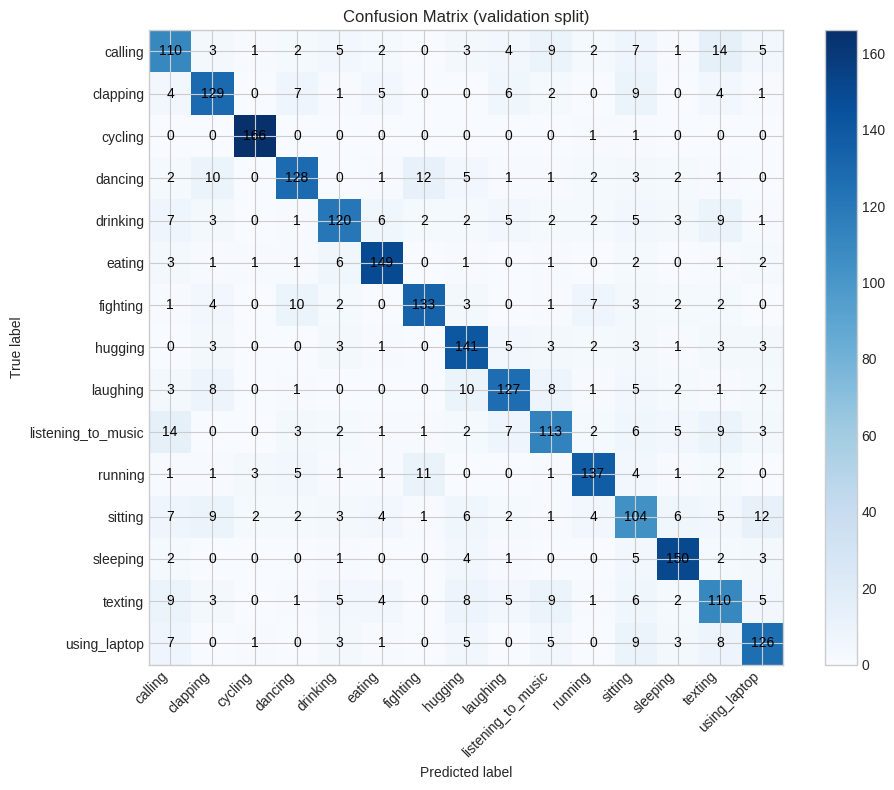

In [ ]:
# Generate a confusion matrix on the validation split
num_classes = len(label_encoder.classes_)

loaded_model = tf.keras.models.load_model('resnet50_best.keras')
val_probs = loaded_model.predict(val_ds)
val_pred_idx = val_probs.argmax(axis=1)
true_labels = val_labels

cm = confusion_matrix(true_labels, val_pred_idx, labels=range(num_classes))
print('Validation classification report:', classification_report(
    true_labels, val_pred_idx, target_names=label_encoder.classes_, zero_division=0,
))

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
ax.set_yticklabels(label_encoder.classes_)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix (validation split)')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


Worst Classes Identification

In [ ]:
# Identify the three worst-performing classes (by recall) on the validation set
per_class_recall = np.diag(cm) / cm.sum(axis=1).clip(min=1)
worst_indices = per_class_recall.argsort()[:3]
worst_classes = [label_encoder.classes_[i] for i in worst_indices]
print("Worst classes by recall (class, recall):", list(zip(worst_classes, per_class_recall[worst_indices].round(3))))

Worst classes by recall (class, recall): [('sitting', np.float64(0.619)), ('calling', np.float64(0.655)), ('texting', np.float64(0.655))]


Stable Diffusion V1.5 text to image

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Synthetic images generated: 300


,filename,label,filepath
0,sitting_sd_00.png,sitting,synthetic_diffusion/sitting/sitting_sd_00.png
1,sitting_sd_01.png,sitting,synthetic_diffusion/sitting/sitting_sd_01.png
2,sitting_sd_02.png,sitting,synthetic_diffusion/sitting/sitting_sd_02.png
3,sitting_sd_03.png,sitting,synthetic_diffusion/sitting/sitting_sd_03.png
4,sitting_sd_04.png,sitting,synthetic_diffusion/sitting/sitting_sd_04.png


Epoch 1/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.9874 - loss: 0.0655 - val_accuracy: 0.7738 - val_loss: 0.8631
Epoch 2/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9940 - loss: 0.0289 - val_accuracy: 0.7627 - val_loss: 0.9105
Epoch 3/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9949 - loss: 0.0215 - val_accuracy: 0.7770 - val_loss: 0.9042
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step
Augmented classification report:                     precision    recall  f1-score   support

           calling       0.65      0.66      0.65       168
          clapping       0.83      0.70      0.76       168
           cycling       0.96      0.99      0.98       168
           dancing       0.78      0.79      0.78       168
          drinking       0.81      0.76      0.79       168
            eating       0.84      0.87      0.86       168
          fighting       0.80      0.84      0.82       168
           hugging       0.79      0.76      0.77       168


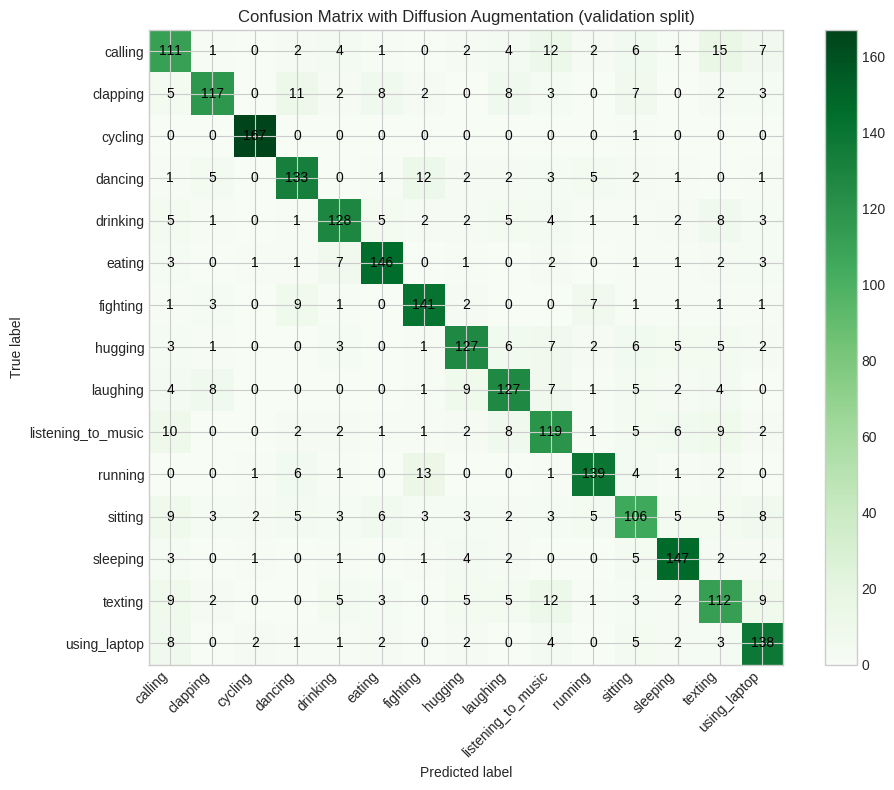

In [ ]:
SYNTHETIC_PER_CLASS = 100  # adjust for more/less synthetic samples per class
synthetic_dir = Path("synthetic_diffusion")
synthetic_dir.mkdir(parents=True, exist_ok=True)

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)
pipe.set_progress_bar_config(disable=True)

synthetic_records = []
for cls in worst_classes:
    prompt = f"photo of a person performing {cls} action, realistic, high resolution"
    class_dir = synthetic_dir / cls.replace(" ", "_")
    class_dir.mkdir(parents=True, exist_ok=True)
    for i in range(SYNTHETIC_PER_CLASS):
        result = pipe(prompt, num_inference_steps=30, guidance_scale=7.5)
        image = result.images[0]
        fname = f"{cls.replace(' ', '_')}_sd_{i:02d}.png"
        fpath = class_dir / fname
        image.save(fpath)
        synthetic_records.append({"filename": fname, "label": cls, "filepath": str(fpath)})

synthetic_df = pd.DataFrame(synthetic_records)
print(f"Synthetic images generated: {len(synthetic_df)}")
display(synthetic_df.head())

if synthetic_df.empty:
    print("No synthetic data generated; skipping augmented training.")
else:
    synthetic_df["label_idx"] = label_encoder.transform(synthetic_df["label"])
    augmented_train_df = pd.concat([train_split, synthetic_df], ignore_index=True)

    aug_train_paths = augmented_train_df["filepath"].astype(str).values
    aug_train_labels = augmented_train_df["label_idx"].values

    aug_train_ds = (
        tf.data.Dataset
        .from_tensor_slices((aug_train_paths, aug_train_labels))
        .shuffle(buffer_size=len(aug_train_paths))
        .map(load_and_preprocess_train, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )

    augmented_model = tf.keras.models.load_model("resnet50_best.keras")
    augmented_history = augmented_model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=3,
        callbacks=[early_stop],
    )
    augmented_model.save("resnet50_augmented.keras")

    aug_val_probs = augmented_model.predict(val_ds)
    aug_val_pred_idx = aug_val_probs.argmax(axis=1)

    aug_cm = confusion_matrix(true_labels, aug_val_pred_idx, labels=range(num_classes))
    print("Augmented classification report:", classification_report(
        true_labels, aug_val_pred_idx, target_names=label_encoder.classes_, zero_division=0,
    ))

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(aug_cm, cmap="Greens")
    fig.colorbar(im, ax=ax)
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(label_encoder.classes_, rotation=45, ha="right")
    ax.set_yticklabels(label_encoder.classes_)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix with Diffusion Augmentation (validation split)")

    for i in range(aug_cm.shape[0]):
        for j in range(aug_cm.shape[1]):
            ax.text(j, i, aug_cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()


Stable Diffusion V1.5 - image to image

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


sitting generated: 100
calling generated: 100
texting generated: 100
Synthetic total: 300
Epoch 1/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.9771 - loss: 0.0850 - val_accuracy: 0.7341 - val_loss: 1.1318 - learning_rate: 1.0000e-04
Epoch 2/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9726 - loss: 0.0830 - val_accuracy: 0.7349 - val_loss: 1.1621 - learning_rate: 1.0000e-04
Epoch 3/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9827 - loss: 0.0649 - val_accuracy: 0.7254 - val_loss: 1.1824 - learning_rate: 1.0000e-04
Epoch 4/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9877 - loss: 0.0431 - val_accuracy: 0.7679 - val_loss: 1.0307 - learning_rate: 5.0000e-05
Epoch 5/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9960 - loss: 0.0172 - val_accuracy: 0.7837 - val_loss: 0.9712 - learning_rate: 5.0000e-05
Epoch 6/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9992 - loss: 0.0081 - val_accuracy: 0.7829 - val_loss: 0.9

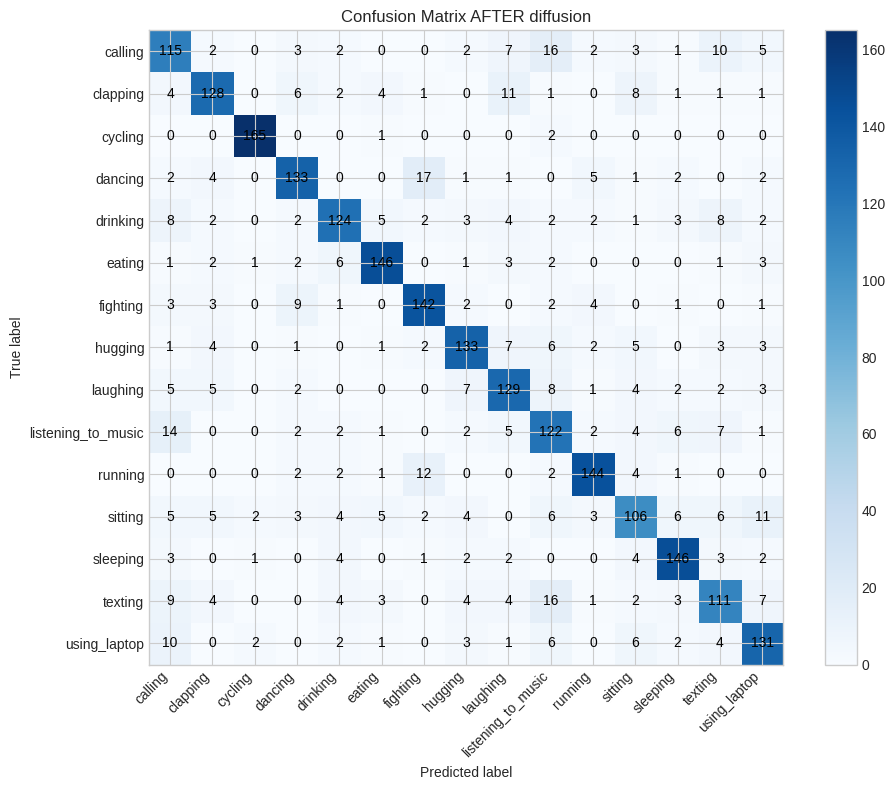

Change in correct predictions per class (after - before):
             calling: +5
            clapping: -1
             cycling: -1
             dancing: +5
            drinking: +4
              eating: -3
            fighting: +9
             hugging: -8
            laughing: +2
  listening_to_music: +9
             running: +7
             sitting: +2
            sleeping: -4
             texting: +1
        using_laptop: +5


In [ ]:
synthetic_dir = Path("/kaggle/working/synthetic_sd15_top2")
synthetic_dir.mkdir(parents=True, exist_ok=True)

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=dtype,
    safety_checker=None,
)
pipe = pipe.to(device)
pipe.set_progress_bar_config(disable=True)

NEG_PROMPT = "blurry, lowres, text, watermark, logo, cartoon, painting, bad anatomy, extra limbs, deformed, distorted hands"

def make_prompt(label_name: str) -> str:
    clean = label_name.replace("_", " ")
    return f"realistic photo of a person {clean}, action shot, natural lighting, high detail, sharp focus"

def generate_for_label(
    label_name: str,
    n_seed_images: int = 25,
    variants_per_seed: int = 4,
    strength: float = 0.45,
    guidance: float = 7.0,
    steps: int = 25,
):
    sub = train_split[train_split["label"] == label_name].copy()
    if len(sub) == 0:
        return pd.DataFrame()

    sub = sub.sample(n=min(n_seed_images, len(sub)), random_state=42)
    rows = []
    prompt = make_prompt(label_name)

    for i, r in sub.iterrows():
        init_img = Image.open(r["filepath"]).convert("RGB").resize((512, 512))

        for v in range(variants_per_seed):
            seed = int(i * 1000 + v)
            g = torch.Generator(device).manual_seed(seed)

            out = pipe(
                prompt=prompt,
                negative_prompt=NEG_PROMPT,
                image=init_img,
                strength=strength,
                guidance_scale=guidance,
                num_inference_steps=steps,
                generator=g,
            ).images[0]

            fname = f"sd15_{label_name}_{i}_{v}.jpg"
            fpath = synthetic_dir / fname
            out.save(fpath, quality=95)

            rows.append({
                "filename": fname,
                "label": label_name,
                "filepath": str(fpath),
                "label_idx": int(r["label_idx"]),
                "is_synthetic": True,
            })

    return pd.DataFrame(rows)

synthetic_parts = []
for cls in worst_classes:
    df_new = generate_for_label(cls)
    print(cls, "generated:", len(df_new))
    synthetic_parts.append(df_new)

synthetic_df = pd.concat(synthetic_parts, ignore_index=True) if synthetic_parts else pd.DataFrame()
print("Synthetic total:", len(synthetic_df))

train_aug = pd.concat(
    [train_split.assign(is_synthetic=False), synthetic_df],
    ignore_index=True
)

counts_idx = train_aug["label_idx"].value_counts().sort_index()
K = len(counts_idx)
N = len(train_aug)
class_weights_aug = {int(k): float(N / (K * v)) for k, v in counts_idx.items()}

train_paths_aug = train_aug["filepath"].astype(str).values
train_labels_aug = train_aug["label_idx"].values

train_ds_aug = (
    tf.data.Dataset.from_tensor_slices((train_paths_aug, train_labels_aug))
    .shuffle(buffer_size=len(train_paths_aug))
    .map(load_and_preprocess_train, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

aud_model = tf.keras.models.load_model("resnet50_best.keras")
aud_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

aud_model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_weights_aug,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

val_probs_aug = aud_model.predict(val_ds, verbose=0)
val_pred_aug = val_probs_aug.argmax(axis=1)

cm_after = confusion_matrix(true_labels, val_pred_aug, labels=range(num_classes))

print("AFTER report:",
      classification_report(true_labels, val_pred_aug,
                            target_names=label_encoder.classes_, zero_division=0))

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_after, cmap='Blues')
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
ax.set_yticklabels(label_encoder.classes_)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix AFTER diffusion')

for i in range(cm_after.shape[0]):
    for j in range(cm_after.shape[1]):
        ax.text(j, i, cm_after[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

delta = np.diag(cm_after) - np.diag(cm)
print("Change in correct predictions per class (after - before):")
for i, cls in enumerate(label_encoder.classes_):
    print(f"{cls:>20s}: {delta[i]:+d}")
aud_model.save("resnet50_SD2.keras")
